In [2]:
from GNNModels.Models import *

import torch
from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/opt/homebrew/anaconda3/envs/DIG_GXAI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the Model

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset_name = "Cora"

dataset = Planetoid(root='/tmp/Planetoid', name=dataset_name, transform=NormalizeFeatures())
data = dataset[0]  # Get the first graph object.

In [4]:
# This is temporary model training, will be replaced with improting pretrained model, having problems with it currently

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)

model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, val_loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc, out


for epoch in range(200):
    loss, val_loss = train()
    if epoch%200 == 0:
          print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

test_acc, out = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 1.9467, Validation loss: 1.9455
Test Accuracy: 0.8080


# Explanation Methods

In [7]:
# %cd GrapthXAI-main
# !pip insall -e .

from graphxai.explainers import GNNExplainer, PGExplainer, IntegratedGradExplainer, PGMExplainer, GradCAM

# the ones below we want to use from different libraries
from graphxai.explainers import GNN_LRP, CAM

# need to also use subgraph x from DIG


## GNN Explainer and PGE Explainer

In [6]:
# GNN Explainer - discrete mask of node imp, soft mask of edge imp

gnnexp = GNNExplainer(model)

def gnn_imp_nodes(node_idx):

    node_exp = gnnexp.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    imp_nodes = []

    for k in node_exp.node_reference.keys():

        if node_exp.node_imp[node_exp.node_reference[k]].item() == 1:

            imp_nodes.append(k)

    return imp_nodes

# PGE Explainer - discrete maks of node imp, discrete mask of edge imp

# needs name of emb layer of the model
pgex = PGExplainer(model, emb_layer_name = 'conv2',  max_epochs = 500, lr = 0.01)
pgex.train_explanation_model(data)

def pge_imp_nodes(node_idx):

    node_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    imp_nodes = []

    for k in node_exp.node_reference.keys():

        if node_exp.node_imp[node_exp.node_reference[k]].item() == 1:

            imp_nodes.append(k)

    return imp_nodes

140it [00:00, 880.30it/s]
140it [00:00, 610.36it/s]
140it [00:00, 617.68it/s]
140it [00:00, 657.71it/s]
140it [00:00, 653.21it/s]
140it [00:00, 331.30it/s]
140it [00:00, 209.13it/s]
140it [00:00, 484.18it/s]
140it [00:00, 478.10it/s]
140it [00:00, 439.05it/s]
140it [00:00, 501.28it/s]
140it [00:00, 500.97it/s]
140it [00:00, 592.88it/s]
140it [00:00, 551.87it/s]
140it [00:00, 536.54it/s]
140it [00:00, 417.11it/s]
140it [00:00, 510.41it/s]
140it [00:00, 528.07it/s]
140it [00:00, 601.81it/s]
140it [00:00, 539.84it/s]
140it [00:00, 555.94it/s]
140it [00:00, 582.61it/s]
140it [00:00, 422.80it/s]
140it [00:00, 653.66it/s]
140it [00:00, 543.19it/s]
140it [00:00, 654.46it/s]
140it [00:00, 720.83it/s]
140it [00:00, 702.49it/s]
140it [00:00, 612.12it/s]
140it [00:00, 561.61it/s]
140it [00:00, 485.99it/s]
140it [00:00, 611.58it/s]
140it [00:00, 405.48it/s]
140it [00:00, 454.26it/s]
140it [00:00, 485.59it/s]
140it [00:00, 421.43it/s]
140it [00:00, 566.00it/s]
140it [00:00, 497.67it/s]
140it [00:00

training time is 125.77s


## Integrated Gradients and PGM Explainer

In [13]:
# Integrated gradients - soft mask of edge imp

igex = IntegratedGradExplainer(model, criterion=criterion)

def ig_imp_nodes(node_idx):

    node_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    imp_nodes = []

    mask = torch.sigmoid(node_exp.node_imp) >= 0.5

    for k in node_exp.node_reference.keys():

        if mask[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes

# PGME Explainer - discrete mask of node imp, randomised, can get ranking as well by asking for top 1 then 2 and so on

pgm = PGMExplainer(model, explain_graph=False)

def pgm_imp_nodes(node_idx, top = None):

    np.random.seed(1998)

    if top == None:

        node_exp = pgm.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)

    else: 

        node_exp = pgm.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, top_k_nodes=top)

    imp_nodes = []

    for k in node_exp.node_reference.keys():

        if node_exp.node_imp[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes

## CAM

In [8]:
# CAM - soft mask of node importanct

camex = CAM(model)

def cam_imp_nodes(node_idx):

    node_exp = camex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    imp_nodes = []

    mask = torch.sigmoid(node_exp.node_imp) >= 0.5

    for k in node_exp.node_reference.keys():

        if mask[node_exp.node_reference[k]].item() == 1:
        
            imp_nodes.append(k)

    return imp_nodes



# Metrics Calculation

In [9]:
# calculates jacard similarity of 2 lists

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection

    if union == 0:
        return float(1)
        
    return float(intersection) / union

In [10]:
out = model(data.x, data.edge_index)

node_idx = 2000

print("Prediction : {}".format(out[node_idx].argmax()))
print("True Class : {}".format(data.y[node_idx]))

Prediction : 3
True Class : 3


In [11]:
(data.test_mask == True).nonzero()

tensor([[1708],
        [1709],
        [1710],
        [1711],
        [1712],
        [1713],
        [1714],
        [1715],
        [1716],
        [1717],
        [1718],
        [1719],
        [1720],
        [1721],
        [1722],
        [1723],
        [1724],
        [1725],
        [1726],
        [1727],
        [1728],
        [1729],
        [1730],
        [1731],
        [1732],
        [1733],
        [1734],
        [1735],
        [1736],
        [1737],
        [1738],
        [1739],
        [1740],
        [1741],
        [1742],
        [1743],
        [1744],
        [1745],
        [1746],
        [1747],
        [1748],
        [1749],
        [1750],
        [1751],
        [1752],
        [1753],
        [1754],
        [1755],
        [1756],
        [1757],
        [1758],
        [1759],
        [1760],
        [1761],
        [1762],
        [1763],
        [1764],
        [1765],
        [1766],
        [1767],
        [1768],
        [1769],
        

In [14]:
imp_nodes_ig = {}
imp_nodes_gnn = {}
imp_nodes_pge = {}
imp_nodes_pgm = {}
imp_nodes_cam = {}

for node_idx in tqdm((data.test_mask == True).nonzero()):

    if out[node_idx].argmax() != data.y[node_idx]:
        continue

    imp_nodes_ig[node_idx] = ig_imp_nodes(node_idx)
    imp_nodes_gnn[node_idx] = gnn_imp_nodes(node_idx)
    imp_nodes_pge[node_idx] = pge_imp_nodes(node_idx)
    imp_nodes_pgm[node_idx] = pgm_imp_nodes(node_idx.item())
    imp_nodes_cam[node_idx] = cam_imp_nodes(node_idx)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  0%|          | 2/1000 [00:02<20:38,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  0%|          | 3/1000 [00:04<26:07,  1.57s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:06<26:39,  1.61s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  0%|          | 5/1000 [00:08<29:46,  1.80s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|          | 6/1000 [00:10<31:21,  1.89s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:12<31:35,  1.91s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  1%|          | 8/1000 [00:14<30:44,  1.86s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|          | 9/1000 [00:15<30:32,  1.85s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|          | 10/1000 [00:17<31:08,  1.89s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:19<29:40,  1.80s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|          | 12/1000 [00:21<30:29,  1.85s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|▏         | 13/1000 [00:23<31:36,  1.92s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  1%|▏         | 14/1000 [00:25<32:43,  1.99s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 15/1000 [00:27<32:41,  1.99s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  2%|▏         | 16/1000 [00:29<31:57,  1.95s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 17/1000 [00:32<36:28,  2.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 18/1000 [00:35<38:24,  2.35s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 19/1000 [00:37<36:50,  2.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 20/1000 [00:39<36:31,  2.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 21/1000 [00:41<35:59,  2.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 22/1000 [00:43<35:40,  2.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▏         | 23/1000 [00:45<33:17,  2.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  2%|▏         | 24/1000 [00:47<31:58,  1.97s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  2%|▎         | 25/1000 [00:49<33:05,  2.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  3%|▎         | 27/1000 [00:51<24:25,  1.51s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  3%|▎         | 29/1000 [00:52<20:04,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  3%|▎         | 30/1000 [00:54<23:23,  1.45s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  3%|▎         | 31/1000 [00:56<24:17,  1.50s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  3%|▎         | 32/1000 [00:59<32:04,  1.99s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  3%|▎         | 33/1000 [01:02<32:37,  2.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▎         | 35/1000 [01:04<25:10,  1.56s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▎         | 36/1000 [01:05<25:47,  1.61s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▎         | 37/1000 [01:07<26:32,  1.65s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▍         | 38/1000 [01:09<27:49,  1.74s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  4%|▍         | 39/1000 [01:11<27:00,  1.69s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▍         | 40/1000 [01:12<27:42,  1.73s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  4%|▍         | 41/1000 [01:14<27:41,  1.73s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  4%|▍         | 42/1000 [01:16<27:20,  1.71s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  4%|▍         | 43/1000 [01:17<26:58,  1.69s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  4%|▍         | 44/1000 [01:20<28:42,  1.80s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  4%|▍         | 45/1000 [01:21<27:41,  1.74s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▍         | 46/1000 [01:23<27:23,  1.72s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▍         | 47/1000 [01:24<27:07,  1.71s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▍         | 48/1000 [01:26<27:20,  1.72s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  5%|▍         | 49/1000 [01:28<27:24,  1.73s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▌         | 50/1000 [01:30<27:46,  1.75s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▌         | 51/1000 [01:31<27:19,  1.73s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  5%|▌         | 52/1000 [01:33<27:06,  1.72s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  5%|▌         | 53/1000 [01:35<27:12,  1.72s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  5%|▌         | 54/1000 [01:37<27:28,  1.74s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 55/1000 [01:38<26:40,  1.69s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 56/1000 [01:40<26:13,  1.67s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 58/1000 [01:42<20:16,  1.29s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 59/1000 [01:43<22:08,  1.41s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 60/1000 [01:44<20:59,  1.34s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▌         | 61/1000 [01:46<20:03,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  6%|▌         | 62/1000 [01:47<20:24,  1.31s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  6%|▋         | 63/1000 [01:48<21:18,  1.36s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▋         | 64/1000 [01:50<21:40,  1.39s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  6%|▋         | 65/1000 [01:51<21:47,  1.40s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 66/1000 [01:52<20:37,  1.32s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  7%|▋         | 68/1000 [01:54<16:54,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 69/1000 [01:55<17:49,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 70/1000 [01:57<18:06,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 71/1000 [01:58<19:10,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 72/1000 [02:00<20:41,  1.34s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 73/1000 [02:01<19:57,  1.29s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  7%|▋         | 74/1000 [02:02<20:44,  1.34s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 75/1000 [02:04<20:26,  1.33s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 76/1000 [02:05<19:31,  1.27s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 77/1000 [02:06<19:32,  1.27s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 78/1000 [02:07<19:10,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 79/1000 [02:08<17:53,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  8%|▊         | 80/1000 [02:10<21:12,  1.38s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 81/1000 [02:11<19:37,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 82/1000 [02:12<18:50,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 83/1000 [02:13<17:30,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  8%|▊         | 84/1000 [02:14<17:19,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▊         | 87/1000 [02:15<10:08,  1.50it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▉         | 88/1000 [02:16<11:02,  1.38it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▉         | 89/1000 [02:17<11:40,  1.30it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▉         | 90/1000 [02:18<14:06,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▉         | 91/1000 [02:20<15:55,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
  9%|▉         | 92/1000 [02:22<19:01,  1.26s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  9%|▉         | 93/1000 [02:23<18:16,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|▉         | 97/1000 [02:24<10:27,  1.44it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|▉         | 98/1000 [02:26<12:24,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|▉         | 99/1000 [02:27<12:43,  1.18it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|█         | 100/1000 [02:28<14:51,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|█         | 101/1000 [02:29<15:46,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|█         | 102/1000 [02:31<18:24,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 10%|█         | 103/1000 [02:33<19:45,  1.32s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 10%|█         | 104/1000 [02:34<19:08,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 10%|█         | 105/1000 [02:35<20:34,  1.38s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 106/1000 [02:37<19:20,  1.30s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 107/1000 [02:38<18:37,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 108/1000 [02:39<18:22,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 109/1000 [02:40<18:03,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 110/1000 [02:41<17:54,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 111/1000 [02:42<18:00,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█         | 112/1000 [02:44<17:56,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 11%|█▏        | 113/1000 [02:45<19:47,  1.34s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 11%|█▏        | 114/1000 [02:47<19:49,  1.34s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 115/1000 [02:48<18:45,  1.27s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 116/1000 [02:49<18:23,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 117/1000 [02:50<17:47,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 118/1000 [02:51<16:52,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 119/1000 [02:52<16:23,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 120/1000 [02:53<15:44,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 121/1000 [02:54<15:10,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 122/1000 [02:55<15:26,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 123/1000 [02:56<15:38,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▏        | 124/1000 [02:57<15:05,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 12%|█▎        | 125/1000 [02:58<14:27,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 126/1000 [02:59<14:14,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 127/1000 [03:00<14:36,  1.00s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 128/1000 [03:01<14:29,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 129/1000 [03:02<14:10,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 130/1000 [03:03<14:18,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 131/1000 [03:04<14:41,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 132/1000 [03:05<15:02,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 13%|█▎        | 134/1000 [03:06<12:07,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▎        | 135/1000 [03:08<13:20,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▎        | 136/1000 [03:09<14:13,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 139/1000 [03:10<10:20,  1.39it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 140/1000 [03:11<11:52,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 141/1000 [03:13<13:20,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 142/1000 [03:14<14:22,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 143/1000 [03:15<15:09,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 14%|█▍        | 145/1000 [03:17<13:38,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▍        | 146/1000 [03:18<15:17,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▍        | 148/1000 [03:20<13:51,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▍        | 149/1000 [03:22<17:40,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▌        | 150/1000 [03:24<18:27,  1.30s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▌        | 151/1000 [03:25<18:17,  1.29s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▌        | 152/1000 [03:26<19:19,  1.37s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▌        | 153/1000 [03:28<20:00,  1.42s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 15%|█▌        | 154/1000 [03:29<19:50,  1.41s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▌        | 155/1000 [03:31<19:39,  1.40s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▌        | 156/1000 [03:32<19:06,  1.36s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 16%|█▌        | 157/1000 [03:34<19:38,  1.40s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▌        | 158/1000 [03:35<19:05,  1.36s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▌        | 159/1000 [03:36<18:57,  1.35s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 16%|█▌        | 160/1000 [03:38<19:09,  1.37s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▌        | 161/1000 [03:39<18:51,  1.35s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 16%|█▌        | 162/1000 [03:41<20:35,  1.47s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▋        | 163/1000 [03:42<20:57,  1.50s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▋        | 164/1000 [03:44<20:05,  1.44s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 16%|█▋        | 165/1000 [03:45<19:19,  1.39s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 166/1000 [03:46<20:03,  1.44s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 167/1000 [03:48<19:26,  1.40s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 17%|█▋        | 168/1000 [03:49<20:41,  1.49s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 169/1000 [03:51<21:26,  1.55s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 170/1000 [03:52<20:10,  1.46s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 171/1000 [03:53<18:37,  1.35s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 172/1000 [03:54<17:43,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 173/1000 [03:56<16:40,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 17%|█▋        | 174/1000 [03:57<16:42,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 175/1000 [03:58<16:45,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 176/1000 [03:59<15:51,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 177/1000 [04:00<15:32,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 178/1000 [04:01<15:07,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 179/1000 [04:02<14:53,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 180/1000 [04:04<16:03,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 181/1000 [04:05<16:10,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 182/1000 [04:06<16:27,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 183/1000 [04:07<15:39,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 18%|█▊        | 184/1000 [04:08<15:35,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▊        | 187/1000 [04:09<10:03,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 188/1000 [04:10<10:50,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 189/1000 [04:12<11:35,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 190/1000 [04:12<11:53,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 191/1000 [04:13<12:22,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 192/1000 [04:15<12:47,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 193/1000 [04:15<12:43,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 19%|█▉        | 194/1000 [04:17<13:31,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 20%|█▉        | 195/1000 [04:18<13:55,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 20%|█▉        | 196/1000 [04:19<14:04,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 20%|█▉        | 197/1000 [04:20<13:50,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 20%|█▉        | 199/1000 [04:21<10:46,  1.24it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 20%|██        | 205/1000 [04:22<05:14,  2.52it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██        | 206/1000 [04:23<06:18,  2.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██        | 207/1000 [04:24<08:08,  1.62it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██        | 208/1000 [04:25<09:14,  1.43it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██        | 209/1000 [04:27<10:34,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 21%|██        | 210/1000 [04:28<12:29,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██        | 212/1000 [04:29<11:04,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 21%|██▏       | 214/1000 [04:30<09:42,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 215/1000 [04:32<10:38,  1.23it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 216/1000 [04:33<11:25,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 218/1000 [04:34<09:42,  1.34it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 219/1000 [04:35<10:52,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 220/1000 [04:36<11:35,  1.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 221/1000 [04:37<12:20,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 222/1000 [04:38<13:01,  1.00s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 223/1000 [04:39<13:25,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▏       | 224/1000 [04:41<13:48,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 22%|██▎       | 225/1000 [04:42<13:45,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 226/1000 [04:43<13:44,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 227/1000 [04:44<13:32,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 228/1000 [04:45<13:43,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 229/1000 [04:46<14:01,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 230/1000 [04:47<13:55,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 231/1000 [04:48<13:18,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 232/1000 [04:49<13:34,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 233/1000 [04:50<13:46,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 234/1000 [04:51<13:50,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▎       | 235/1000 [04:52<14:05,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▎       | 237/1000 [04:53<10:34,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 238/1000 [04:55<11:19,  1.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 239/1000 [04:56<11:48,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 240/1000 [04:57<12:12,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 241/1000 [04:58<12:46,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 242/1000 [04:59<13:09,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 243/1000 [05:00<13:21,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 244/1000 [05:01<13:06,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 24%|██▍       | 245/1000 [05:02<13:24,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▍       | 246/1000 [05:03<13:26,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▍       | 247/1000 [05:04<13:51,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▍       | 248/1000 [05:05<13:25,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▍       | 249/1000 [05:06<13:14,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▌       | 250/1000 [05:08<13:40,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▌       | 251/1000 [05:09<13:56,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▌       | 252/1000 [05:10<13:30,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▌       | 253/1000 [05:11<13:08,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 25%|██▌       | 254/1000 [05:12<12:47,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 255/1000 [05:13<12:54,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 256/1000 [05:14<12:40,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 257/1000 [05:15<12:45,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 258/1000 [05:16<12:32,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 259/1000 [05:17<13:28,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 260/1000 [05:18<13:18,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 261/1000 [05:19<13:44,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▌       | 262/1000 [05:20<13:32,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▋       | 263/1000 [05:21<13:25,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▋       | 264/1000 [05:23<13:33,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 26%|██▋       | 265/1000 [05:24<13:10,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 267/1000 [05:25<10:08,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 268/1000 [05:26<11:12,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 269/1000 [05:27<11:37,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 271/1000 [05:28<10:06,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 272/1000 [05:30<11:28,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 273/1000 [05:31<11:45,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 27%|██▋       | 274/1000 [05:32<12:16,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 275/1000 [05:33<12:37,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 277/1000 [05:34<09:50,  1.23it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 28%|██▊       | 279/1000 [05:36<10:05,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 280/1000 [05:37<11:11,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 281/1000 [05:38<12:04,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 284/1000 [05:39<08:38,  1.38it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 28%|██▊       | 285/1000 [05:41<09:58,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 29%|██▊       | 286/1000 [05:42<11:18,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▊       | 287/1000 [05:43<12:13,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▉       | 288/1000 [05:45<12:54,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▉       | 289/1000 [05:46<13:33,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▉       | 290/1000 [05:47<14:03,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▉       | 292/1000 [05:49<11:21,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 29%|██▉       | 293/1000 [05:50<12:09,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 29%|██▉       | 294/1000 [05:51<13:23,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|██▉       | 295/1000 [05:53<14:02,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|██▉       | 297/1000 [05:54<11:30,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|██▉       | 298/1000 [05:55<12:17,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|██▉       | 299/1000 [05:57<12:51,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|███       | 300/1000 [05:58<13:34,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|███       | 301/1000 [05:59<14:25,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 30%|███       | 302/1000 [06:01<14:32,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 30%|███       | 304/1000 [06:02<11:33,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 31%|███       | 309/1000 [06:03<06:16,  1.84it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 31%|███       | 310/1000 [06:05<07:22,  1.56it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 31%|███       | 311/1000 [06:06<08:16,  1.39it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 31%|███▏      | 313/1000 [06:07<07:34,  1.51it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 31%|███▏      | 314/1000 [06:08<08:49,  1.29it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 32%|███▏      | 315/1000 [06:09<09:31,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 32%|███▏      | 319/1000 [06:10<06:10,  1.84it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 32%|███▏      | 322/1000 [06:11<05:20,  2.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 32%|███▏      | 323/1000 [06:12<06:27,  1.75it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 327/1000 [06:14<05:31,  2.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 328/1000 [06:15<06:49,  1.64it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 329/1000 [06:17<08:02,  1.39it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 330/1000 [06:18<08:57,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 333/1000 [06:19<07:02,  1.58it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 33%|███▎      | 334/1000 [06:20<08:13,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▎      | 336/1000 [06:21<07:23,  1.50it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 34%|███▍      | 338/1000 [06:23<08:26,  1.31it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 339/1000 [06:25<09:46,  1.13it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 341/1000 [06:26<09:03,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 342/1000 [06:27<09:28,  1.16it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 343/1000 [06:28<10:29,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 344/1000 [06:30<10:59,  1.00s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 34%|███▍      | 345/1000 [06:31<11:20,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▍      | 346/1000 [06:32<11:25,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▍      | 347/1000 [06:33<12:21,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▍      | 348/1000 [06:34<12:43,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▍      | 349/1000 [06:36<12:43,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▌      | 350/1000 [06:37<12:33,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▌      | 352/1000 [06:38<09:28,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▌      | 353/1000 [06:39<09:54,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 35%|███▌      | 354/1000 [06:40<10:02,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 355/1000 [06:41<10:14,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 356/1000 [06:42<10:24,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 357/1000 [06:43<10:32,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 358/1000 [06:44<10:56,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 359/1000 [06:45<10:58,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 360/1000 [06:46<10:53,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 361/1000 [06:47<10:58,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▌      | 362/1000 [06:48<10:53,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▋      | 363/1000 [06:49<11:12,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 36%|███▋      | 365/1000 [06:50<08:46,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 366/1000 [06:51<09:32,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 367/1000 [06:53<10:09,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 368/1000 [06:54<10:31,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 369/1000 [06:55<10:51,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 370/1000 [06:56<10:55,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 372/1000 [06:57<08:30,  1.23it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 373/1000 [06:58<09:55,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 37%|███▋      | 374/1000 [06:59<10:27,  1.00s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 375/1000 [07:01<10:37,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 38%|███▊      | 377/1000 [07:02<09:25,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 38%|███▊      | 378/1000 [07:04<10:48,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 379/1000 [07:05<11:56,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 380/1000 [07:06<12:42,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 381/1000 [07:08<13:11,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 383/1000 [07:09<10:36,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 384/1000 [07:11<11:32,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 38%|███▊      | 385/1000 [07:12<11:58,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▊      | 386/1000 [07:13<12:08,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▊      | 387/1000 [07:15<12:29,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▉      | 388/1000 [07:16<12:23,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▉      | 389/1000 [07:17<12:05,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▉      | 390/1000 [07:18<11:29,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▉      | 391/1000 [07:19<11:00,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 39%|███▉      | 392/1000 [07:20<11:09,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|███▉      | 397/1000 [07:21<04:54,  2.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|███▉      | 399/1000 [07:22<04:57,  2.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|████      | 400/1000 [07:23<06:05,  1.64it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|████      | 402/1000 [07:24<05:55,  1.68it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|████      | 403/1000 [07:25<06:46,  1.47it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 40%|████      | 405/1000 [07:27<06:22,  1.56it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 406/1000 [07:28<07:20,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 407/1000 [07:29<08:53,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 408/1000 [07:30<09:25,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 409/1000 [07:31<09:37,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 410/1000 [07:32<09:53,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████      | 411/1000 [07:33<10:07,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████▏     | 413/1000 [07:35<08:08,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 41%|████▏     | 414/1000 [07:36<08:53,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 415/1000 [07:37<09:25,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 416/1000 [07:38<10:01,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 420/1000 [07:39<05:37,  1.72it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 421/1000 [07:40<06:33,  1.47it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 422/1000 [07:41<07:14,  1.33it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 423/1000 [07:43<08:25,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▏     | 424/1000 [07:44<09:32,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 42%|████▎     | 425/1000 [07:46<10:54,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 426/1000 [07:47<11:20,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 427/1000 [07:48<11:05,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 428/1000 [07:49<10:56,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 429/1000 [07:50<11:03,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 430/1000 [07:51<10:46,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 431/1000 [07:53<10:52,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 432/1000 [07:54<10:38,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 433/1000 [07:55<10:32,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 43%|████▎     | 434/1000 [07:56<10:16,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▎     | 435/1000 [07:57<10:04,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▎     | 436/1000 [07:58<10:11,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▎     | 437/1000 [07:59<10:07,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 438/1000 [08:00<10:15,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 439/1000 [08:01<10:11,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 440/1000 [08:02<10:08,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 441/1000 [08:03<09:58,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 444/1000 [08:04<06:20,  1.46it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 44%|████▍     | 445/1000 [08:06<07:25,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▍     | 447/1000 [08:07<06:42,  1.37it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▍     | 448/1000 [08:08<08:01,  1.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▍     | 449/1000 [08:10<08:51,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▌     | 450/1000 [08:11<09:18,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▌     | 451/1000 [08:12<09:21,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▌     | 452/1000 [08:13<09:31,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▌     | 453/1000 [08:14<09:37,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 45%|████▌     | 454/1000 [08:15<09:42,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▌     | 455/1000 [08:16<09:44,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▌     | 456/1000 [08:17<09:55,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▌     | 457/1000 [08:18<09:48,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▌     | 458/1000 [08:20<10:14,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▋     | 464/1000 [08:21<04:09,  2.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 46%|████▋     | 465/1000 [08:22<05:38,  1.58it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 47%|████▋     | 469/1000 [08:24<04:10,  2.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 47%|████▋     | 471/1000 [08:25<04:39,  1.89it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 47%|████▋     | 472/1000 [08:27<06:04,  1.45it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 47%|████▋     | 473/1000 [08:28<07:03,  1.24it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 47%|████▋     | 474/1000 [08:29<08:11,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 475/1000 [08:31<09:19,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 476/1000 [08:32<09:37,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 477/1000 [08:33<09:35,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 478/1000 [08:34<09:37,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 479/1000 [08:36<09:59,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 482/1000 [08:37<06:30,  1.33it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 483/1000 [08:38<07:06,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 48%|████▊     | 485/1000 [08:39<06:23,  1.34it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▊     | 486/1000 [08:40<06:51,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▊     | 487/1000 [08:41<07:30,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 488/1000 [08:42<07:55,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 489/1000 [08:44<08:20,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 490/1000 [08:45<09:01,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 491/1000 [08:46<09:41,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 492/1000 [08:48<10:07,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 493/1000 [08:49<10:00,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 49%|████▉     | 494/1000 [08:50<10:03,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|████▉     | 495/1000 [08:51<10:01,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|████▉     | 496/1000 [08:52<09:45,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|████▉     | 497/1000 [08:53<09:25,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|████▉     | 498/1000 [08:54<09:30,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|████▉     | 499/1000 [08:56<09:26,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|█████     | 500/1000 [08:57<09:22,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|█████     | 502/1000 [08:58<07:03,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|█████     | 503/1000 [08:59<07:28,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|█████     | 504/1000 [09:00<07:52,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 50%|█████     | 505/1000 [09:01<08:14,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 506/1000 [09:02<08:19,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 507/1000 [09:03<08:35,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 508/1000 [09:04<08:44,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 509/1000 [09:05<08:48,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 510/1000 [09:07<09:10,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 511/1000 [09:08<08:56,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████     | 512/1000 [09:09<08:56,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████▏    | 513/1000 [09:10<09:09,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 51%|█████▏    | 514/1000 [09:11<09:25,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 515/1000 [09:12<09:16,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 516/1000 [09:13<09:09,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 517/1000 [09:14<08:57,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 518/1000 [09:15<08:45,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 519/1000 [09:17<09:00,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 520/1000 [09:18<09:00,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 522/1000 [09:19<06:46,  1.18it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▏    | 523/1000 [09:20<07:15,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 52%|█████▎    | 525/1000 [09:21<06:12,  1.27it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 526/1000 [09:22<06:52,  1.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 527/1000 [09:23<07:12,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 528/1000 [09:25<07:42,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 529/1000 [09:26<07:59,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 530/1000 [09:27<08:21,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 531/1000 [09:28<08:46,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 532/1000 [09:29<09:17,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 533/1000 [09:31<09:23,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 53%|█████▎    | 534/1000 [09:32<09:22,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▎    | 535/1000 [09:33<09:06,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▎    | 536/1000 [09:34<08:56,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▎    | 537/1000 [09:35<08:56,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 538/1000 [09:36<08:55,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 540/1000 [09:38<06:56,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 541/1000 [09:39<07:36,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 542/1000 [09:40<08:07,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 543/1000 [09:41<08:18,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 54%|█████▍    | 544/1000 [09:42<08:16,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▍    | 545/1000 [09:44<08:13,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▍    | 546/1000 [09:45<08:10,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▍    | 547/1000 [09:46<08:06,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▍    | 549/1000 [09:47<06:26,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▌    | 551/1000 [09:48<05:24,  1.39it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▌    | 552/1000 [09:49<06:01,  1.24it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▌    | 553/1000 [09:50<06:29,  1.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 55%|█████▌    | 554/1000 [09:51<06:54,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 555/1000 [09:52<07:20,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 557/1000 [09:53<05:46,  1.28it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 558/1000 [09:54<06:17,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 559/1000 [09:56<06:44,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 560/1000 [09:57<07:09,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▌    | 562/1000 [09:58<05:54,  1.23it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▋    | 563/1000 [09:59<06:35,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▋    | 564/1000 [10:00<07:05,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 56%|█████▋    | 565/1000 [10:01<07:29,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 566/1000 [10:03<07:53,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 567/1000 [10:04<08:11,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 568/1000 [10:05<08:16,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 570/1000 [10:06<06:22,  1.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 571/1000 [10:07<06:47,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 572/1000 [10:09<07:19,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 573/1000 [10:10<07:39,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 57%|█████▋    | 574/1000 [10:11<07:50,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 576/1000 [10:12<06:19,  1.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 577/1000 [10:13<06:43,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 578/1000 [10:15<07:01,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 579/1000 [10:16<07:11,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 580/1000 [10:17<07:24,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 581/1000 [10:18<07:36,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 582/1000 [10:19<07:42,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 583/1000 [10:20<07:43,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 58%|█████▊    | 585/1000 [10:21<05:54,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▊    | 587/1000 [10:23<05:14,  1.31it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 588/1000 [10:24<06:04,  1.13it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 589/1000 [10:25<06:24,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 590/1000 [10:26<06:36,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 591/1000 [10:27<06:53,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 592/1000 [10:28<07:05,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 593/1000 [10:30<07:28,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 59%|█████▉    | 594/1000 [10:31<07:45,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|█████▉    | 596/1000 [10:32<06:16,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|█████▉    | 597/1000 [10:34<06:55,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|█████▉    | 598/1000 [10:35<07:05,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 600/1000 [10:36<05:46,  1.16it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 601/1000 [10:37<06:06,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 602/1000 [10:38<06:42,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 603/1000 [10:39<06:56,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 604/1000 [10:41<07:15,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 60%|██████    | 605/1000 [10:42<07:18,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 61%|██████    | 608/1000 [10:43<04:43,  1.38it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 61%|██████    | 610/1000 [10:44<04:23,  1.48it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 61%|██████    | 611/1000 [10:45<04:58,  1.30it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 61%|██████▏   | 613/1000 [10:46<04:31,  1.43it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 61%|██████▏   | 614/1000 [10:48<05:09,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 615/1000 [10:49<05:36,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 617/1000 [10:50<04:52,  1.31it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 618/1000 [10:51<05:22,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 620/1000 [10:52<04:38,  1.36it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 621/1000 [10:53<05:12,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 622/1000 [10:54<05:39,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 623/1000 [10:56<06:02,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 62%|██████▏   | 624/1000 [10:57<06:19,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 626/1000 [10:58<05:21,  1.16it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 627/1000 [10:59<05:48,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 628/1000 [11:01<06:25,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 629/1000 [11:02<06:36,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 630/1000 [11:03<06:42,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 631/1000 [11:04<06:49,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 632/1000 [11:05<06:48,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 63%|██████▎   | 633/1000 [11:06<07:00,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▎   | 635/1000 [11:08<05:49,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▎   | 636/1000 [11:09<06:22,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▎   | 637/1000 [11:11<06:55,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▍   | 640/1000 [11:12<04:56,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▍   | 643/1000 [11:14<04:06,  1.45it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▍   | 644/1000 [11:15<04:56,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 64%|██████▍   | 645/1000 [11:17<05:50,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 65%|██████▍   | 646/1000 [11:18<06:23,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 65%|██████▍   | 649/1000 [11:20<04:23,  1.33it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 65%|██████▌   | 651/1000 [11:21<04:06,  1.42it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 65%|██████▌   | 654/1000 [11:22<03:21,  1.72it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 655/1000 [11:23<03:56,  1.46it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 656/1000 [11:24<04:22,  1.31it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 657/1000 [11:25<04:47,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 658/1000 [11:27<05:11,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 659/1000 [11:28<05:26,  1.04it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 660/1000 [11:29<05:54,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 661/1000 [11:30<06:18,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▌   | 662/1000 [11:32<06:40,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▋   | 663/1000 [11:33<06:39,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 66%|██████▋   | 664/1000 [11:34<06:43,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 667/1000 [11:35<04:16,  1.30it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 668/1000 [11:37<05:13,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 669/1000 [11:38<05:34,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 670/1000 [11:39<05:48,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 671/1000 [11:41<05:57,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 672/1000 [11:42<06:02,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 673/1000 [11:43<06:04,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 67%|██████▋   | 674/1000 [11:44<06:19,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 675/1000 [11:45<06:21,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 676/1000 [11:47<06:34,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 677/1000 [11:48<06:28,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 679/1000 [11:49<05:00,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 680/1000 [11:50<05:23,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 682/1000 [11:52<04:29,  1.18it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 683/1000 [11:53<04:57,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 684/1000 [11:54<05:20,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 68%|██████▊   | 685/1000 [11:55<05:32,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 69%|██████▊   | 686/1000 [11:56<05:39,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 69%|██████▉   | 691/1000 [11:57<02:39,  1.94it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 69%|██████▉   | 692/1000 [11:59<03:17,  1.56it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 69%|██████▉   | 693/1000 [12:00<03:50,  1.33it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 69%|██████▉   | 694/1000 [12:01<04:19,  1.18it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|██████▉   | 696/1000 [12:02<03:45,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|██████▉   | 697/1000 [12:03<04:11,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|███████   | 700/1000 [12:05<03:08,  1.59it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|███████   | 701/1000 [12:06<03:35,  1.39it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|███████   | 703/1000 [12:07<03:17,  1.50it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|███████   | 704/1000 [12:08<03:43,  1.32it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 70%|███████   | 705/1000 [12:09<04:13,  1.17it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 707/1000 [12:10<03:39,  1.33it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 708/1000 [12:12<04:04,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 709/1000 [12:13<04:22,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 710/1000 [12:14<04:34,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 711/1000 [12:15<04:58,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████   | 712/1000 [12:16<05:10,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████▏  | 713/1000 [12:17<05:13,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 71%|███████▏  | 714/1000 [12:19<05:14,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 715/1000 [12:20<05:22,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 717/1000 [12:21<04:07,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 719/1000 [12:22<03:49,  1.22it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 721/1000 [12:24<03:35,  1.30it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 722/1000 [12:25<04:06,  1.13it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 723/1000 [12:26<04:42,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▏  | 724/1000 [12:28<05:01,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 72%|███████▎  | 725/1000 [12:29<05:20,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 73%|███████▎  | 727/1000 [12:31<04:37,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 73%|███████▎  | 728/1000 [12:32<04:51,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 73%|███████▎  | 732/1000 [12:33<02:53,  1.55it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 73%|███████▎  | 733/1000 [12:35<03:28,  1.28it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 73%|███████▎  | 734/1000 [12:36<03:56,  1.12it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▎  | 735/1000 [12:38<04:32,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▎  | 736/1000 [12:39<04:54,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▎  | 737/1000 [12:40<05:13,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 738/1000 [12:42<05:19,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 739/1000 [12:43<05:21,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 740/1000 [12:44<05:22,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 741/1000 [12:46<05:27,  1.26s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 742/1000 [12:47<05:20,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 74%|███████▍  | 743/1000 [12:48<05:33,  1.30s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 744/1000 [12:50<05:34,  1.31s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 74%|███████▍  | 745/1000 [12:51<05:22,  1.26s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▍  | 746/1000 [12:52<05:13,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▍  | 747/1000 [12:53<05:09,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▍  | 748/1000 [12:54<04:59,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▌  | 750/1000 [12:55<03:50,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▌  | 751/1000 [12:57<04:02,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▌  | 752/1000 [12:58<04:17,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 75%|███████▌  | 754/1000 [12:59<03:25,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 76%|███████▌  | 756/1000 [13:00<03:04,  1.32it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 76%|███████▌  | 757/1000 [13:01<03:30,  1.16it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 76%|███████▌  | 758/1000 [13:03<03:45,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 76%|███████▌  | 759/1000 [13:04<03:58,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 76%|███████▋  | 764/1000 [13:05<02:03,  1.91it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 766/1000 [13:06<02:06,  1.84it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 767/1000 [13:07<02:28,  1.56it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 768/1000 [13:09<02:52,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 769/1000 [13:10<03:20,  1.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 770/1000 [13:11<03:34,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 771/1000 [13:12<03:46,  1.01it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 772/1000 [13:13<03:52,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 773/1000 [13:14<03:58,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 77%|███████▋  | 774/1000 [13:16<04:11,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 776/1000 [13:17<03:16,  1.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 779/1000 [13:18<02:20,  1.57it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 780/1000 [13:19<02:41,  1.36it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 781/1000 [13:20<03:01,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 782/1000 [13:22<03:17,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 784/1000 [13:23<02:48,  1.28it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 78%|███████▊  | 785/1000 [13:24<03:12,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▊  | 786/1000 [13:25<03:28,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▊  | 787/1000 [13:26<03:38,  1.03s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 788/1000 [13:28<03:48,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 790/1000 [13:29<03:02,  1.15it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 791/1000 [13:30<03:17,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 792/1000 [13:31<03:38,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 793/1000 [13:33<03:43,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 79%|███████▉  | 794/1000 [13:34<03:47,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|███████▉  | 795/1000 [13:35<03:48,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|███████▉  | 796/1000 [13:36<04:05,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|███████▉  | 797/1000 [13:37<04:01,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|███████▉  | 798/1000 [13:39<03:55,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|███████▉  | 799/1000 [13:40<03:52,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 800/1000 [13:41<03:57,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 801/1000 [13:42<03:58,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 802/1000 [13:43<03:58,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 803/1000 [13:45<03:53,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 804/1000 [13:46<03:51,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 80%|████████  | 805/1000 [13:47<03:49,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 806/1000 [13:48<03:49,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 807/1000 [13:49<03:48,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 808/1000 [13:51<03:51,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 809/1000 [13:52<03:53,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 810/1000 [13:53<03:48,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 811/1000 [13:54<03:49,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████  | 812/1000 [13:55<03:49,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████▏ | 813/1000 [13:57<03:50,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 81%|████████▏ | 814/1000 [13:58<03:43,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 815/1000 [13:59<03:44,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 816/1000 [14:00<03:43,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 817/1000 [14:02<03:46,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 818/1000 [14:03<03:44,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 819/1000 [14:04<03:39,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 820/1000 [14:05<03:33,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 821/1000 [14:06<03:36,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 822/1000 [14:07<03:32,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 823/1000 [14:09<03:33,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▏ | 824/1000 [14:10<03:31,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 82%|████████▎ | 825/1000 [14:11<03:30,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 827/1000 [14:12<02:40,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 828/1000 [14:14<02:51,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 829/1000 [14:15<02:58,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 830/1000 [14:16<03:00,  1.06s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 831/1000 [14:17<03:13,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 832/1000 [14:18<03:16,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 833/1000 [14:20<03:14,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 83%|████████▎ | 834/1000 [14:21<03:13,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▎ | 836/1000 [14:22<02:30,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▎ | 837/1000 [14:23<02:42,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 839/1000 [14:24<02:15,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 840/1000 [14:26<02:28,  1.08it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 841/1000 [14:27<02:42,  1.02s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 842/1000 [14:28<02:52,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 843/1000 [14:30<03:01,  1.15s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 844/1000 [14:31<03:07,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 84%|████████▍ | 845/1000 [14:32<03:08,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▍ | 847/1000 [14:33<02:24,  1.06it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▍ | 848/1000 [14:35<02:32,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▌ | 850/1000 [14:36<02:05,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▌ | 851/1000 [14:37<02:19,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▌ | 852/1000 [14:38<02:27,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 85%|████████▌ | 853/1000 [14:39<02:33,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 86%|████████▌ | 855/1000 [14:41<02:03,  1.18it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 86%|████████▌ | 856/1000 [14:42<02:14,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 86%|████████▌ | 857/1000 [14:43<02:23,  1.00s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 86%|████████▌ | 861/1000 [14:44<01:20,  1.72it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 86%|████████▋ | 863/1000 [14:45<01:20,  1.71it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 866/1000 [14:47<01:09,  1.93it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 867/1000 [14:48<01:23,  1.60it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 868/1000 [14:49<01:35,  1.38it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 869/1000 [14:50<01:47,  1.22it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 870/1000 [14:51<01:59,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 872/1000 [14:53<01:44,  1.22it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 87%|████████▋ | 874/1000 [14:54<01:33,  1.35it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 875/1000 [14:55<01:43,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 876/1000 [14:56<01:52,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 878/1000 [14:58<01:37,  1.25it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 880/1000 [14:59<01:28,  1.36it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 881/1000 [15:00<01:39,  1.19it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 882/1000 [15:01<01:49,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 884/1000 [15:03<01:34,  1.22it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 88%|████████▊ | 885/1000 [15:04<01:44,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▊ | 886/1000 [15:05<01:50,  1.03it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▊ | 887/1000 [15:06<01:57,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▉ | 888/1000 [15:08<02:03,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▉ | 889/1000 [15:09<02:08,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/sgupta/opt/anaconda3/envs/FML/lib/python3.10/site-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
 89%|████████▉ | 890/1000 [15:11<02:36,  1.42s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▉ | 891/1000 [15:12<02:28,  1.36s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▉ | 892/1000 [15:13<02:23,  1.33s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 89%|████████▉ | 894/1000 [15:15<01:45,  1.00it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|████████▉ | 897/1000 [15:16<01:12,  1.43it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|████████▉ | 898/1000 [15:17<01:22,  1.23it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|█████████ | 901/1000 [15:18<01:02,  1.59it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|█████████ | 902/1000 [15:19<01:11,  1.36it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|█████████ | 903/1000 [15:21<01:20,  1.21it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 90%|█████████ | 905/1000 [15:22<01:09,  1.36it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 91%|█████████ | 906/1000 [15:23<01:18,  1.20it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 91%|█████████ | 907/1000 [15:24<01:26,  1.07it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 91%|█████████ | 909/1000 [15:25<01:12,  1.26it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 91%|█████████▏| 914/1000 [15:27<00:40,  2.14it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 915/1000 [15:28<00:48,  1.74it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 916/1000 [15:29<00:57,  1.45it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 917/1000 [15:30<01:05,  1.26it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 918/1000 [15:32<01:13,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 919/1000 [15:33<01:19,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 920/1000 [15:34<01:23,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 921/1000 [15:35<01:25,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 922/1000 [15:36<01:26,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 923/1000 [15:38<01:29,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▏| 924/1000 [15:39<01:28,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 92%|█████████▎| 925/1000 [15:40<01:28,  1.17s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 926/1000 [15:41<01:28,  1.19s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 927/1000 [15:43<01:28,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 928/1000 [15:44<01:27,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 929/1000 [15:45<01:33,  1.32s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 930/1000 [15:47<01:40,  1.43s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 931/1000 [15:49<01:43,  1.50s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 93%|█████████▎| 934/1000 [15:50<01:02,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▎| 935/1000 [15:52<01:09,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▎| 936/1000 [15:54<01:17,  1.21s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 938/1000 [15:55<01:05,  1.05s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 939/1000 [15:56<01:07,  1.10s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 940/1000 [15:58<01:07,  1.13s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 941/1000 [15:59<01:12,  1.23s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 942/1000 [16:01<01:13,  1.27s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 943/1000 [16:02<01:12,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 944/1000 [16:03<01:13,  1.31s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 94%|█████████▍| 945/1000 [16:04<01:11,  1.30s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▍| 946/1000 [16:06<01:10,  1.30s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▌| 950/1000 [16:07<00:34,  1.46it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▌| 951/1000 [16:08<00:38,  1.26it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▌| 952/1000 [16:10<00:42,  1.13it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▌| 953/1000 [16:11<00:44,  1.05it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 95%|█████████▌| 954/1000 [16:12<00:46,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 955/1000 [16:13<00:48,  1.07s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 956/1000 [16:14<00:48,  1.11s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 958/1000 [16:16<00:37,  1.11it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 959/1000 [16:17<00:40,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 960/1000 [16:18<00:43,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▌| 961/1000 [16:20<00:44,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▋| 963/1000 [16:21<00:33,  1.10it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▋| 964/1000 [16:22<00:36,  1.01s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 96%|█████████▋| 965/1000 [16:23<00:38,  1.09s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 966/1000 [16:25<00:38,  1.14s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 967/1000 [16:26<00:38,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 968/1000 [16:27<00:38,  1.20s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 969/1000 [16:29<00:37,  1.22s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 970/1000 [16:30<00:37,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 971/1000 [16:31<00:35,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 972/1000 [16:33<00:36,  1.31s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 973/1000 [16:34<00:34,  1.29s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 97%|█████████▋| 974/1000 [16:35<00:33,  1.27s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 975/1000 [16:36<00:31,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 976/1000 [16:37<00:29,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 977/1000 [16:39<00:29,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 978/1000 [16:40<00:28,  1.28s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 979/1000 [16:41<00:26,  1.26s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 980/1000 [16:42<00:24,  1.24s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 981/1000 [16:44<00:23,  1.25s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 984/1000 [16:45<00:12,  1.31it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▊| 986/1000 [16:46<00:09,  1.42it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▊| 987/1000 [16:47<00:10,  1.24it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 988/1000 [16:49<00:10,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 989/1000 [16:50<00:10,  1.02it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 990/1000 [16:51<00:10,  1.04s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 991/1000 [16:52<00:09,  1.08s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 992/1000 [16:53<00:08,  1.12s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 993/1000 [16:55<00:08,  1.16s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 994/1000 [16:56<00:07,  1.18s/it]

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|█████████▉| 996/1000 [16:57<00:03,  1.09it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [16:58<00:00,  1.49it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [17:00<00:00,  1.02s/it]


In [15]:
n_methods = 5

jacard = np.zeros((n_methods, n_methods))

count = 0
for k in imp_nodes_ig.keys():

    count += 1

    jacard[0, 1] += jaccard(imp_nodes_ig[k], imp_nodes_gnn[k])
    jacard[0, 2] += jaccard(imp_nodes_ig[k], imp_nodes_pge[k])
    jacard[0, 3] += jaccard(imp_nodes_ig[k], imp_nodes_cam[k])
    jacard[0, 4] += jaccard(imp_nodes_ig[k], imp_nodes_pgm[k])

    jacard[1, 2] += jaccard(imp_nodes_gnn[k], imp_nodes_pge[k])
    jacard[1, 3] += jaccard(imp_nodes_gnn[k], imp_nodes_cam[k])
    jacard[1, 4] += jaccard(imp_nodes_gnn[k], imp_nodes_pgm[k])


    jacard[2, 3] += jaccard(imp_nodes_pge[k], imp_nodes_cam[k])
    jacard[2, 4] += jaccard(imp_nodes_pge[k], imp_nodes_pgm[k])

    jacard[3, 4] += jaccard(imp_nodes_cam[k], imp_nodes_pgm[k])



jacard = (jacard + jacard.T)/(count)

for i in range(n_methods):

    jacard[i,i] = 1

    

<AxesSubplot:>

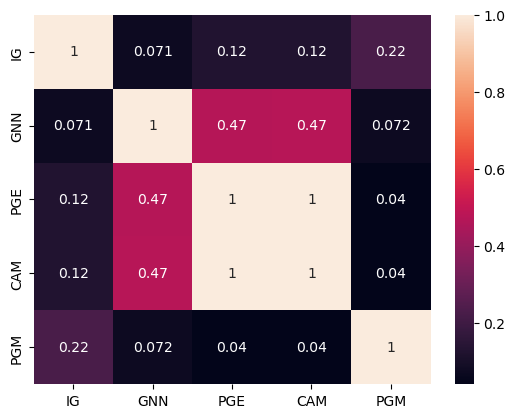

In [16]:
labels = ["IG", "GNN", "PGE", "CAM", "PGM"]
jacard_df = pd.DataFrame(jacard, index = labels, columns = labels)
sns.heatmap(jacard_df, annot=True)

In [17]:
from torch_geometric.utils import to_networkx

G = to_networkx(data)


In [20]:
import networkx as nx

nx.hits(G)

({0: 6.8905694127965804e-06,
  1: 7.2764060585297955e-06,
  2: 0.00010357902071558718,
  3: 9.256301316654696e-22,
  4: 0.0003572757817871566,
  5: 5.327612084542883e-05,
  6: 2.2511583268361423e-05,
  7: 3.539893660115576e-22,
  8: 2.5437768724396364e-05,
  9: 2.185931125802072e-05,
  10: 2.608088532787897e-05,
  11: 4.822716750435952e-06,
  12: -6.460156824595209e-21,
  13: 5.4142739060877755e-05,
  14: 1.6716886184684473e-05,
  15: 8.724609451059203e-08,
  16: 0.0004755997910520808,
  17: 5.647928663232693e-06,
  18: 4.184827961942505e-05,
  19: 5.971364511297124e-08,
  20: 0.0005004540187356686,
  21: 6.803520207580117e-08,
  22: 9.428130829935265e-07,
  23: 4.377900562252718e-22,
  24: 7.501124441076173e-05,
  25: 7.249092085771418e-06,
  26: -5.590000190423341e-21,
  27: 1.2645465146953263e-05,
  28: 4.227986064614021e-05,
  29: 6.897163221001991e-07,
  30: 0.0036040024334311554,
  31: 9.58582534040384e-22,
  32: 5.765647619915082e-06,
  33: 1.9330450998387525e-06,
  34: 0.003510